# Generalized ReLU Feature Map Regression

In this notebook we will:
- (a) Implement a `GenRelu` class that computes the feature map

$$
\phi\left(x \mid x_0\right)= \begin{cases}x-x_0, & \text { if } x>x_0 \\ a\left(x-x_0\right), & \text { if } x \leq x_0\end{cases}
$$

where each $x_0$ is a "location" and $a$ is a hyperparameter in $[-1,1]$. 

- (b) Plot the feature functions for three different values of $a$ (namely, $-0.5,0$, and 0.1 ) over a grid of 10 equally spaced points in $[-2,2]$.

- (c) Use the `GenRelu` features to perform regression on both a periodic dataset and a polynomial dataset. For each, we will tune the hyperparameter $a$ (via grid search) to find the best fit and compare with a simple B-Spline (ReLU) feature mapping.

- (d) Generate a Brownian motion path and, for different numbers of equally spaced "location" points, find the optimal $a$ and plot the regression fits. We will discuss whether increasing the number of features improves the fit. 

## Setup and Imports

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import lstsq
import scipy.interpolate as si
from sklearn.base import TransformerMixin

# For reproducibility
np.random.seed(42)

%matplotlib inline

## (a) Implementing the GenRelu Class

We define a class `GenRelu` which takes an array of location points and a hyperparameter a (defaulted to -1 ). The `transform` method computes the feature matrix for a given array of input values $x$. For each location $x_0$ the feature is given by
- $x-x_0$ if $x>x_0$,
- $a\left(x-x_0\right)$ if $x \leq x_0$.

We use broadcasting so that if `X` is a vector of inputs and `locations` is a vector of thresholds, we obtain a design matrix of shape (`len(X)`, `len(locations)`).

In [2]:
class GenRelu:
    def __init__(self, locations, a=-1.0):
        """
        Initialize the GenRelu feature map.
        
        Parameters:
        locations : array-like
            The knot/threshold locations x0.
        a : float
            The hyperparameter for the negative (or below threshold) region.
        """
        self.locations = np.array(locations)
        self.a = a

    def transform(self, X):
        """
        Compute the feature map for input values X.
        
        Parameters:
        X : array-like, shape (n_samples,)
        
        Returns:
        features : ndarray, shape (n_samples, n_features)
            The feature matrix where each column corresponds to a location.
        """
        X = np.array(X).reshape(-1, 1)  # Ensure X is a column vector
        diff = X - self.locations.reshape(1, -1)
        features = np.where(X > self.locations, diff, self.a * diff)
        return features

# Quick test of the GenRelu class on a single point:
x_test = np.array([0.5])
locations_test = np.linspace(-1, 1, 5)
genrelu = GenRelu(locations=locations_test, a=-0.5)
print("Features for x=0.5:", genrelu.transform(x_test))

Features for x=0.5: [[ 1.5   1.    0.5  -0.    0.25]]


## (b) Plotting the Features for Different Values of $a$

We now plot the feature functions for three different values of $a$ (namely $-0.5,0$, and 0.1 ) on a grid of 10 equally spaced points in $[-2,2]$. For each $a$ value the features are generated for a fixed set of locations (which we take to be 10 equally spaced points in $[-2,2]$ ).

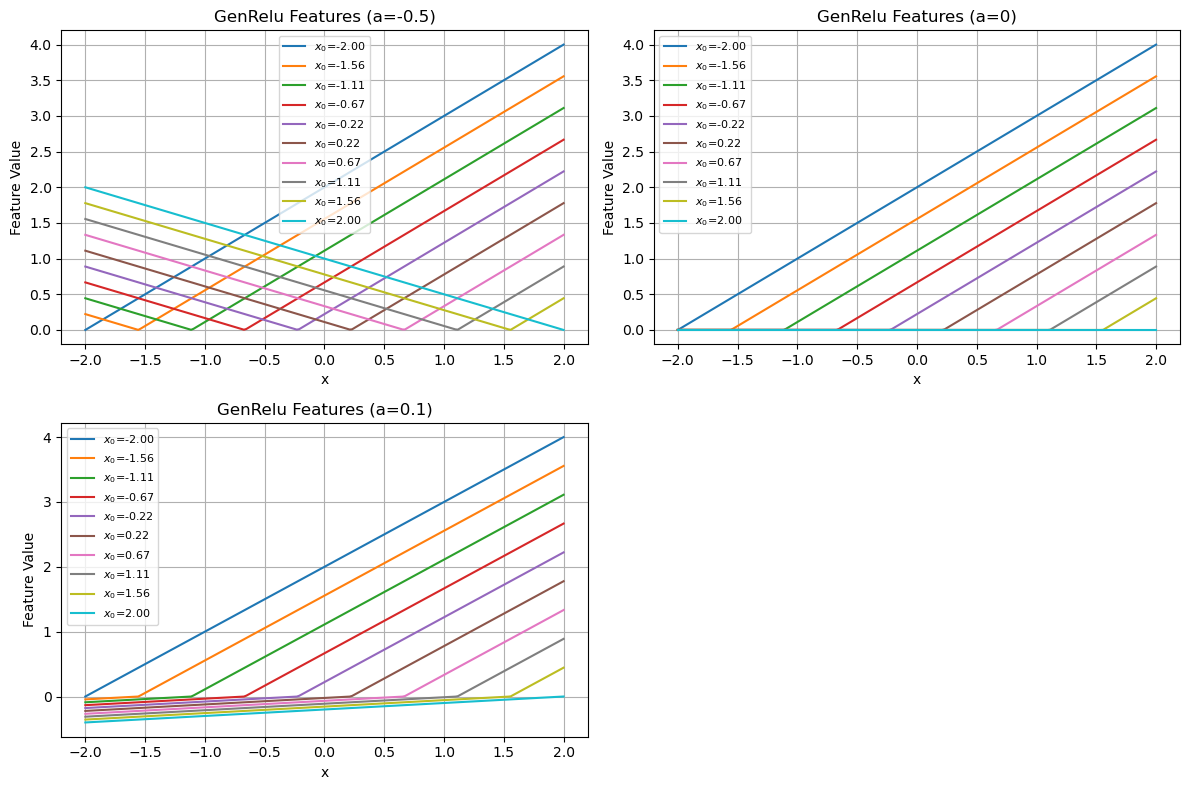

In [3]:
# Define the grid for x and the locations
x_grid = np.linspace(-2, 2, 200)  # for smooth curves when plotting
locations = np.linspace(-2, 2, 10)  # 10 equally spaced location points

# The different values of a to test
a_values = [-0.5, 0, 0.1]

plt.figure(figsize=(12, 8))
for i, a in enumerate(a_values):
    # Initialize GenRelu with the given a
    feature_map = GenRelu(locations, a=a)
    # Compute the feature matrix: shape = (len(x_grid), number_of_locations)
    features = feature_map.transform(x_grid)
    
    # Plot each feature (each column corresponds to a feature function)
    plt.subplot(2, 2, i+1)
    for j in range(features.shape[1]):
        plt.plot(x_grid, features[:, j], label=f'$x_0$={locations[j]:.2f}')
    plt.title(f'GenRelu Features (a={a})')
    plt.xlabel('x')
    plt.ylabel('Feature Value')
    plt.legend(fontsize=8)
    plt.grid(True)
plt.tight_layout()
plt.show()

## (c) Regression on Periodic and Polynomial Datasets

We now test the GenRelu regression on two datasets:
- **Polynomial Data:**  
  - $X$ is drawn uniformly from $[-2,2]$ with $N=200$ samples.
  - The true function is  
    $$
    y_{\text{true\_poly}} = 2 + 2X + 0.4X^2 - 0.4X^3.
    $$
  - Observations $y_{\text{poly}}$ are perturbed by Gaussian noise (std = 0.2) and 10% outliers.

- **Periodic Data:**  
  - We use the same $X$ values.
  - The function is  
    $$
    y_{\text{periodic}} = \sin(2\pi X)
    $$
    (since $20 \pi \cdot 0.1 = 2\pi$) with additional Gaussian noise (std = 0.2).

For each dataset, we tune the hyperparameter $a$ (over a grid from -1 to 1 ) by computing the leastsquares fit (using our feature map) and selecting the $a$ that minimizes the mean squared error (MSE). For comparison we also compute a fit using a B-Spline-like feature map. Here we define a simple class that mimics the ReLU feature map (which corresponds to a GenRelu with $a=0$ ).

### Data Generation

In [ ]:
N = 200
X = np.random.uniform(-2, 2, N)

# --- Polynomial Data ---
y_true_poly = 2 + 2*X + 0.4*X**2 - 0.4*X**3
y_poly = y_true_poly + 0.2 * np.random.randn(N)
# Introduce 10% outliers
n_outliers = int(0.1 * N)
outlier_indices = np.random.choice(N, n_outliers, replace=False)
y_poly[outlier_indices] += np.random.uniform(5, 10, n_outliers)

# --- Periodic Data ---
x_periodic = X.copy()
y_periodic = np.sin(20 * np.pi * 0.1 * X)  # sin(2*pi*X)
y_periodic += 0.2 * np.random.randn(N)

# For smoother plotting, sort the data by X
sort_idx_poly = np.argsort(X)
X_poly_sorted = X[sort_idx_poly]
y_poly_sorted = y_poly[sort_idx_poly]

sort_idx_per = np.argsort(x_periodic)
x_periodic_sorted = x_periodic[sort_idx_per]
y_periodic_sorted = y_periodic[sort_idx_per]

### Define BSplineFeatures Class

In [5]:
def get_bspline_basis(knots, degree=3, periodic=False):
    """Get spline coefficients for each basis spline given the knots."""
    nknots = len(knots)
    y_dummy = np.zeros(nknots)
    # Compute the tck representation using splrep
    knots, coeffs, degree = si.splrep(knots, y_dummy, k=degree, per=periodic)
    ncoeffs = len(coeffs)
    bsplines = []
    for ispline in range(nknots):
        # Create new coefficients: only the current basis function is 1, others 0
        coeffs_new = [1.0 if ispl == ispline else 0.0 for ispl in range(ncoeffs)]
        bsplines.append((knots, coeffs_new, degree))
    return bsplines

class BSplineFeatures(TransformerMixin):
    def __init__(self, knots, degree=3, periodic=False):
        self.bsplines = get_bspline_basis(knots, degree, periodic=periodic)
        self.nsplines = len(self.bsplines)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Parameters:
        - X: ndarray, shape (nsamples, nfeatures)
        
        Returns:
        - features: ndarray, shape (nsamples, nfeatures * nsplines)
        """
        nsamples, nfeatures = X.shape
        features = np.zeros((nsamples, nfeatures * self.nsplines))
        for ispline, spline in enumerate(self.bsplines):
            istart = ispline * nfeatures
            iend = (ispline + 1) * nfeatures
            # Evaluate the spline: flatten X, then reshape back to (nsamples, nfeatures)
            features[:, istart:iend] = si.splev(X.flatten(), spline).reshape(nsamples, nfeatures)
        return features

### Helper Functions for Regression and Hyperparameter Tuning

In [ ]:
def linear_regression_fit(Phi, y):
    """
    Fit a linear model using least squares given the feature matrix Phi and target y.
    
    Returns:
    - w: weight vector,
    - y_pred: predictions,
    - mse: mean squared error.
    """
    w, _, _, _ = lstsq(Phi, y, rcond=None)
    y_pred = Phi.dot(w)
    mse = np.mean((y - y_pred) ** 2)
    return w, y_pred, mse

def tune_hyperparameter_a(X, y, locations, a_grid):
    """
    Tune the hyperparameter a for GenRelu features using grid search.
    
    Returns:
    - best_a: the a value that minimizes the MSE,
    - mse_values: a dictionary mapping each a to its MSE.
    """
    mse_values = {}
    for a in a_grid:
        feature_map = GenRelu(locations, a=a)
        Phi = feature_map.transform(X)
        _, _, mse = linear_regression_fit(Phi, y)
        mse_values[a] = mse
    best_a = min(mse_values, key=mse_values.get)
    return best_a, mse_values

def plot_regression_results(X, y, X_plot, y_pred, title):
    plt.figure(figsize=(8, 4))
    plt.scatter(X, y, color='gray', label='Data', zorder=3)
    plt.plot(X_plot, y_pred, color='red', lw=2, label='Model')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

### Periodic Dataset

Optimal a for periodic dataset: 0.8


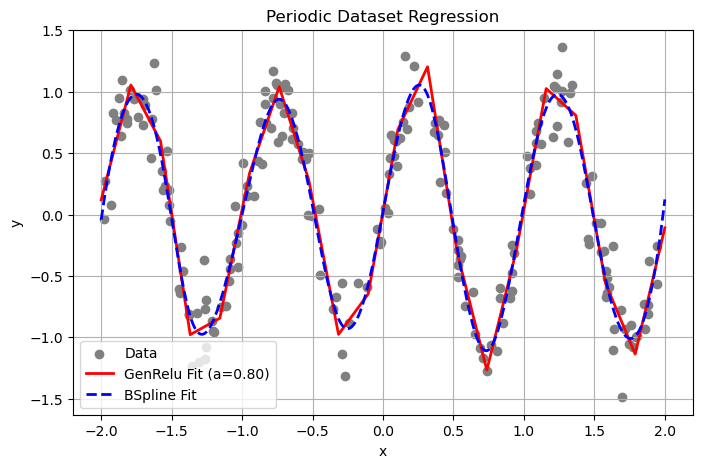

In [ ]:
# Set knots for the periodic dataset
locations_periodic = np.linspace(-2, 2, 20)
a_grid = np.linspace(-1, 1, 21)

# Reshape data for BSplineFeatures (expects a 2D array)
x_periodic_sorted_2d = x_periodic_sorted.reshape(-1, 1)

# Tune hyperparameter a for the periodic dataset
best_a_periodic, mse_values_periodic = tune_hyperparameter_a(x_periodic_sorted, y_periodic_sorted, locations_periodic, a_grid)
print(f"Optimal a for periodic dataset: {best_a_periodic}")

# Regression using GenRelu features
genrelu_periodic = GenRelu(locations_periodic, a=best_a_periodic)
Phi_periodic = genrelu_periodic.transform(x_periodic_sorted)
w_periodic, _, _ = linear_regression_fit(Phi_periodic, y_periodic_sorted)

# Predict on a dense grid
X_dense_per = np.linspace(-2, 2, 400)
Phi_dense_per = genrelu_periodic.transform(X_dense_per)
y_pred_periodic = Phi_dense_per.dot(w_periodic)

# Regression using BSplineFeatures
bspline = BSplineFeatures(locations_periodic)
Phi_bspline = bspline.transform(x_periodic_sorted_2d)
w_bspline, _, _ = linear_regression_fit(Phi_bspline, y_periodic_sorted)
Phi_dense_bspline = bspline.transform(X_dense_per.reshape(-1, 1))
y_pred_bspline = Phi_dense_bspline.dot(w_bspline)

# Plot the comparison
plt.figure(figsize=(8,5))
plt.scatter(x_periodic_sorted, y_periodic_sorted, color='gray', label='Data')
plt.plot(X_dense_per, y_pred_periodic, color='red', lw=2, label=f'GenRelu Fit (a={best_a_periodic:.2f})')
plt.plot(X_dense_per, y_pred_bspline, color='blue', lw=2, ls='--', label='BSpline Fit')
plt.title('Periodic Dataset Regression')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

### Polynomial Dataset

Optimal a for polynomial dataset: 0.6000000000000001


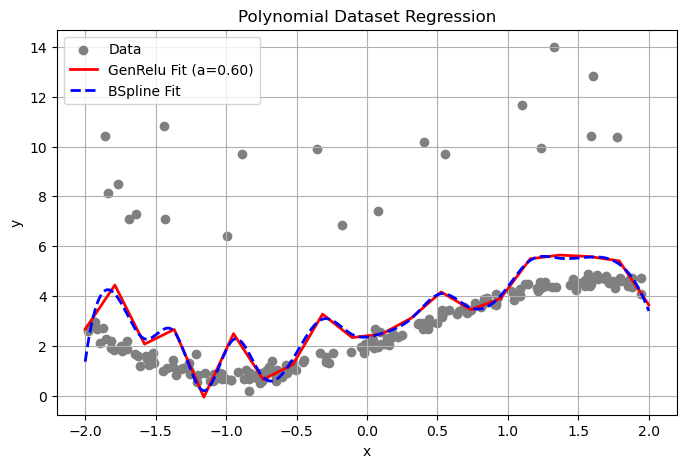

In [ ]:
# Set knots for the polynomial dataset
locations_poly = np.linspace(-2, 2, 20)
x_poly_sorted_2d = X_poly_sorted.reshape(-1, 1)

# Tune hyperparameter a for the polynomial dataset
best_a_poly, mse_values_poly = tune_hyperparameter_a(X_poly_sorted, y_poly_sorted, locations_poly, a_grid)
print(f"Optimal a for polynomial dataset: {best_a_poly}")

# Regression using GenRelu features
genrelu_poly = GenRelu(locations_poly, a=best_a_poly)
Phi_poly = genrelu_poly.transform(X_poly_sorted)
w_poly, _, _ = linear_regression_fit(Phi_poly, y_poly_sorted)

# Predict on a dense grid
X_dense_poly = np.linspace(-2, 2, 400)
Phi_dense_poly = genrelu_poly.transform(X_dense_poly)
y_pred_poly = Phi_dense_poly.dot(w_poly)

# Regression using BSplineFeatures
bspline_poly = BSplineFeatures(locations_poly)
Phi_bspline_poly = bspline_poly.transform(x_poly_sorted_2d)
w_bspline_poly, _, _ = linear_regression_fit(Phi_bspline_poly, y_poly_sorted)
Phi_dense_bspline_poly = bspline_poly.transform(X_dense_poly.reshape(-1, 1))
y_pred_bspline_poly = Phi_dense_bspline_poly.dot(w_bspline_poly)

# Plot the comparison
plt.figure(figsize=(8,5))
plt.scatter(X_poly_sorted, y_poly_sorted, color='gray', label='Data')
plt.plot(X_dense_poly, y_pred_poly, color='red', lw=2, label=f'GenRelu Fit (a={best_a_poly:.2f})')
plt.plot(X_dense_poly, y_pred_bspline_poly, color='blue', lw=2, ls='--', label='BSpline Fit')
plt.title('Polynomial Dataset Regression')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

**Discussion of Results:**

We can see that `GenRelu` is sharper than `BSpline` by the nature of its feature mapping. 

## (d) Regression on a Brownian Motion Path

For this section we:
1. Generate a Brownian motion path $W_t$ for $t \in[0,1]$ with 100 equally spaced time points. We use `np.random.normal` with seed 42 to simulate increments and then take the cumulative sum.
2. For different numbers $K$ of equally spaced location points in $[0,1]$ (with $K=5,20,50,100$ ), we fit the Brownian motion path using GenRelu regression.
3. For each $K$, we tune $a$ and plot the resulting regression fit versus the true BM path.

K = 5: Optimal a = 0.9000000000000001
K = 20: Optimal a = 0.20000000000000018
K = 50: Optimal a = 0.8
K = 100: Optimal a = -0.6


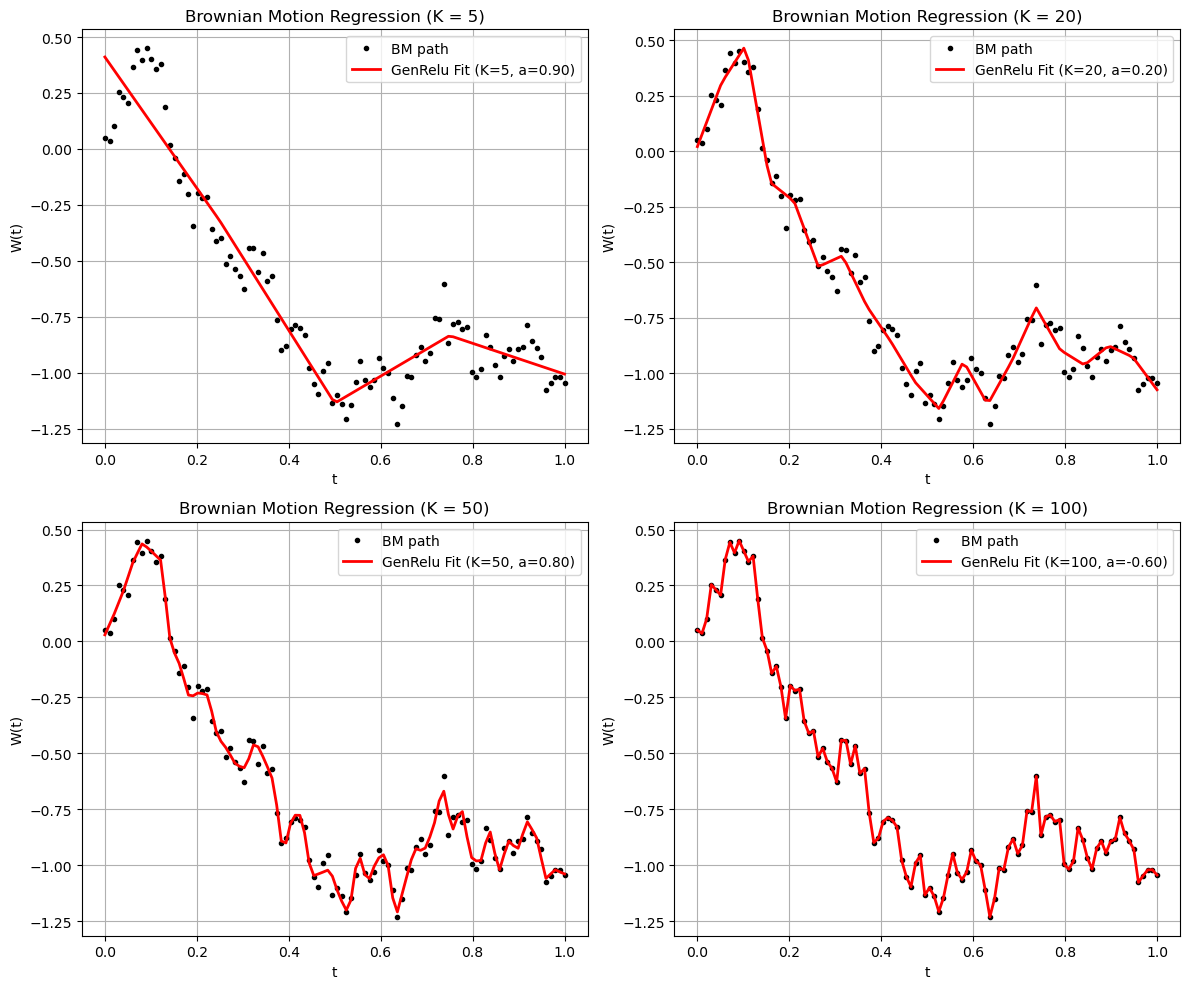

In [9]:
# Set seed for BM generation
np.random.seed(42)

# Time discretization
T = 1.0
n_points = 100
t = np.linspace(0, T, n_points)
dt = t[1] - t[0]

# Generate Brownian motion path: cumulative sum of N(0, sqrt(dt)) increments
increments = np.random.normal(0, np.sqrt(dt), size=n_points)
W = np.cumsum(increments)

# Define different numbers of location points to test
K_values = [5, 20, 50, 100]
a_grid_bm = np.linspace(-1, 1, 21)

plt.figure(figsize=(12, 10))
for idx, K in enumerate(K_values):
    # Create K equally spaced location points in [0,1]
    locations_bm = np.linspace(0, 1, K)
    # Tune the hyperparameter a for the BM path
    best_a_bm, mse_values_bm = tune_hyperparameter_a(t, W, locations_bm, a_grid_bm)
    print(f"K = {K}: Optimal a = {best_a_bm}")
    
    # Fit using the optimal a
    genrelu_bm = GenRelu(locations_bm, a=best_a_bm)
    Phi_bm = genrelu_bm.transform(t)
    w_bm, _, _ = linear_regression_fit(Phi_bm, W)
    
    # Predict on the original time grid
    y_pred_bm = genrelu_bm.transform(t).dot(w_bm)
    
    # Plot the fit against the true Brownian motion path
    plt.subplot(2, 2, idx+1)
    plt.plot(t, W, 'k.', label='BM path')
    plt.plot(t, y_pred_bm, 'r-', lw=2, label=f'GenRelu Fit (K={K}, a={best_a_bm:.2f})')
    plt.title(f'Brownian Motion Regression (K = {K})')
    plt.xlabel('t')
    plt.ylabel('W(t)')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

**Discussion of Results:**

As you can observe from the plots and the optimal $a$ values printed:
- For smaller $K$ (fewer features), the regression fit is very coarse.
- As $K$ increases, the model has more flexibility. However, even though the optimal $a$ might vary with $K$, the Brownian motion path itself is highly irregular. This means that-beyond a point-the increased number of features may lead to overfitting the noise inherent in the BM path rather than capturing a smooth trend.
- In practice, we must balance model complexity (number of features $K$ ) and the choice of $a$. The plots help to see whether increasing $K$ leads to a better approximation of the underlying process or if it starts to capture too much noise.

## Final Remarks

In this notebook we:
- Developed a generalized ReLU feature mapping that allows for a tunable negative slope parameter $a$.
- Visualized how changing $a$ affects the feature functions.
- Applied these features to regression tasks on periodic and polynomial datasets-finding different optimal $a$ values.
- Explored the effect of increasing the number of features $K$ when fitting a Brownian motion path, noting the trade-off between model flexibility and noise fitting.

---

End of the notebook. 